In [1]:
from fastai.vision import *
from fastai.vision.all import *
import torch
import torchvision
import torch.nn as nn
from loss_functions.triplet_loss import TripletLoss
from fastai.vision.augment import *
from fastai.vision.learner import cnn_learner
from fastai.vision.models import resnet34
from fastai.metrics import accuracy
from fastai.data.core import DataLoaders
from scipy import spatial
import logging

In [2]:
import fastai
fastai.__version__

'2.3.2'

In [3]:
torch.cuda.is_available()

True

In [4]:
class L2_norm(nn.Module):
    def __init__(self):
        super(L2_norm, self).__init__()

    def forward(self, x):
        return F.normalize(x, p=2, dim=-1)

In [5]:
device = 0
torch.cuda.set_device(device)

In [6]:
batch_size = 128
size = 28

In [7]:
tfms = aug_transforms()

In [8]:
from fastai.basics import *
mnist = untar_data(URLs.MNIST)
tfms = aug_transforms(do_flip=False)

In [9]:
fnames = get_image_files(mnist)
def label_func(x): return x.parent.name
dls = ImageDataLoaders.from_path_func(mnist, fnames, label_func)

In [10]:
# dls.valid_dl.new(shuffle=True)
# Original is a fastai data (valid_dl etc.)

In [12]:
learn = cnn_learner(dls, resnet34, metrics=accuracy, loss_func=TripletLoss(device))

In [13]:
learn.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=10, bias=False)
)

In [236]:
# out_features_count = 128
out_features_count = 4

In [237]:
layers = learn.model[1]
learn.model[1] = nn.Sequential(layers[0], layers[1], layers[2], layers[3], nn.Linear(in_features=1024, out_features=out_features_count, bias=False), L2_norm()).to(device)
    

SuggestedLRs(lr_min=0.002754228748381138, lr_steep=0.0003311311302240938)

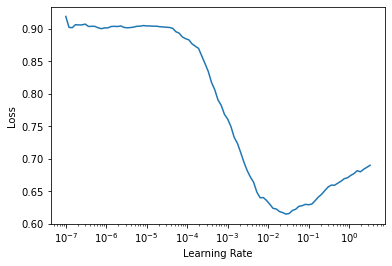

In [238]:
learn.lr_find()

In [ ]:
lr = 0.0002
epochs = 100
learn.fit_one_cycle(epochs, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.746077,0.293546,0.000500,00:29
1,0.514373,0.240476,0.000429,00:29
2,0.356138,0.159343,0.000643,00:29
3,0.197945,0.068402,0.000571,00:29
4,0.100318,0.049595,0.001000,00:29
5,0.058414,0.043318,0.009286,00:29
6,0.027147,0.042105,0.025429,00:29
7,0.017346,0.041576,0.021143,00:29
8,0.011594,0.040571,0.019857,00:29
9,0.011474,0.039593,0.004500,00:29


In [ ]:
model_name = f'{epochs}_epochs_{out_features_count}_features'

In [ ]:
learn.save(model_name)

## Now, how to inference? 

Move this section down below fingerprinting. 

In [ ]:
img = PILImage.create('Star1.png')

In [ ]:
result = learn.predict(img)
fingerprint = result[1].numpy()
print(fingerprint)

In [ ]:
len(fingerprint)

## Train a same/not-same classifier

Based on https://stackoverflow.com/questions/45255030/how-to-determine-accuracy-with-triplet-loss-in-a-convolutional-neural-network

Delete this section

In [ ]:
class ClassifierNet(nn.Module):
    def __init__(self, model):
        super(ClassifierNet, self).__init__()
        self.embeddingLayer = model
        self.classifierLayer = nn.Linear(128,62)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.dropout(self.embeddingLayer(x))
        x = self.classifierLayer(x)
        return F.log_softmax(x, dim=1)
    
yesNoNet = ClassifierNet(learn.model)

TODO: Train this on yes / no pairs

## Nearest k-neighbors

based on https://github.com/sanku-lib/image_triplet_loss/blob/master/Prediction.ipynb

In [ ]:
fnames = list(Path(mnist/'testing').rglob('*.png'))
len(fnames)

In [ ]:
fnames[0]

In [ ]:
# Outputs a blank line for each for some reason. Use %%capture --no-std-err when calling
def fingerprint_all(fnames):
    fingerprints = {}
    for f in fnames:
        category = label_func(f)
        img = PILImage.create(f)
        result = learn.predict(img)
        fingerprint = result[1].numpy()
        fingerprints[(category,f)] = fingerprint
    return fingerprints


In [ ]:
%%capture
# Suppress 
# Takes about 3 minutes on a 2080
fingerprint_db = fingerprint_all(Path(mnist/'testing').rglob('*.png'))

In [ ]:
# Find k nearest neighbour using cosine similarity
def find_k_nn(vectors,vec,k):
    dist_arr = np.matmul(vectors, vec.T)
    return np.argsort(-dist_arr.flatten())[:k]


In [ ]:
fps = list(fingerprint_db.values())
len(fps[0])

In [ ]:
find_k_nn(fps, fingerprint, 10)

In [ ]:
list(fingerprint_db.items())[5823]

In [ ]:


def best_match_mnist(fingerprint_db, fingerprint, k):
    fps = list(fingerprint_db.values())
    keys = list(fingerprint_db.keys())
    match_indices = find_k_nn(fps,fingerprint,k)
    for i in match_indices:
        match_fp = fps[i]
        distance = spatial.distance.cosine(match_fp, fingerprint)
        yield (keys[i], distance)
        
list(best_match_mnist(fingerprint_db, fingerprint, 10))

In [ ]:
def fingerprint_file(path) :
    img = PILImage.create(path)
    result = learn.predict(img)
    fingerprint = result[1].numpy()
    return fingerprint

fp = fingerprint_file('4.png')
list(best_match_mnist(fingerprint_db, fp, 5))

In [ ]:
fp4 = fingerprint_file('4.png')

In [ ]:
list(best_match_mnist(fingerprint_db, fp4, 5))

In [ ]:
fps1 = fingerprint_file('Star1.png')
fps2 = fingerprint_file('Star2.png')
list(best_match_mnist(fingerprint_db, fps1, 1))

In [ ]:
spatial.distance.cosine(fps2, fps1)

In [ ]:
list(best_match_mnist(fingerprint_db, fps2, 1))

In [ ]:
fingerprint_db[('*','/Star1.png')] = fps1

In [ ]:
(list(m for m in best_match_mnist(fingerprint_db, fps2, 10)))

In [ ]:
(list(m for m in best_match_mnist(fingerprint_db, fps2, 10000) if m[0][0] != "8"))[0:10]

In [ ]:
query_img = PILImage.create("Star2.png")
query_img

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [ ]:
%matplotlib inline

In [ ]:
PILImage.create("Star1.png")

I think this net is overfitted to numbers. But does that make sense? Shouldn't just... features to features create the appropriate cosine distance between star and star?

Or, maybe it's that the best diagnostic is: "OK, return the top 3 returns in the top 3 categories." So you'd get "8"s and their <0.04 distance, and you'd get FPS1 at 0.04, and then you'd get the top (whatever) 

In [ ]:
from sklearn.manifold import TSNE
from matplotlib import cm


In [ ]:
fps = np.array(list(fingerprint_db.values()))
fps.shape

In [ ]:
def train_and_fingerprint(epochs, learning_rate, files_to_fingerprint) :
    learn.fit_one_cycle(epochs,slice(learning_rate))
    fingerprints = fingerprint_all(files_to_fingerprint)
    
    return (learn, fingerprints)

In [ ]:
import matplotlib.patches as patches

def visualize(fingerprints_db, fingerprints_to_highlight = [], indices_to_highlight = []):
    l = list(fingerprint_db.values())
    fps = np.array(l + fingerprints_to_highlight)
    tsne = TSNE(2, random_state = 42, verbose = 1)    
    tsne_proj = tsne.fit_transform(fps)
    
    cmap = cm.get_cmap('tab20')
    fig, ax = plt.subplots(figsize=(8,8))
    num_categories = 11

    for i in range(num_categories):
        matching_indices = [key for key, (val,_) in enumerate(fingerprint_db.keys()) if val == str(i)]
        plt.scatter(tsne_proj[matching_indices,0], tsne_proj[matching_indices,1], c = np.array(cmap(i)).reshape(1,4), label = i)
    ax.legend(fontsize='large', markerscale=2)
    
    # Highlight
    plt.scatter(tsne_proj[indices_to_highlight,0], tsne_proj[indices_to_highlight,1], marker = '+', c = 'k', label = 'highlight') 
    ixs_to_highlight = range(len(fps) - len(fingerprints_to_highlight),len(fps))
    (xs, ys) = (tsne_proj[ixs_to_highlight,0], tsne_proj[ixs_to_highlight,1])
    plt.scatter(xs, ys, marker = '+', c = 'k', label = 'highlight') 
    (min_x, min_y, max_x, max_y) = (min(xs), min(ys), max(xs), max(ys))
    min_x = min_x - 2
    min_y = min_y - 2
    width = max_x - min_x + 2
    height = max_y - min_y + 2
    rect = patches.Rectangle((min_x, min_y), width, height, linewidth=1, edgecolor='k', facecolor='none')
    ax.add_patch(rect)
    
    plt.savefig(model_name)
    plt.show()
    return tsne

In [ ]:
%%capture 
# Use %%capture to suppress fingerprint_all output, which produces a blank line for each file for some reason
(_, fps) = train_and_fingerprint(0, .0005, fnames)

In [ ]:
visualize(fps, fingerprints_to_highlight = [fps1, fps2])